# YOLO code

In [33]:
import torch

batch = {
    'img': torch.randn(4, 3, 640, 640),
    'cls': torch.tensor([[22., 22., 45., 45., 50., 45., 49., 49., 49., 49., 45., 45., 58., 75., 23., 23., 45., 45., 49., 49., 49., 49.]]).T,
    'bboxes': torch.randn(22, 4),
    'batch_idx': torch.tensor([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.])
}


In [ ]:
import ultralytics
args = ultralytics.utils.IterableSimpleNamespace(
# task='detect',
# mode='train',
# model='yolo11n.pt',
# data='/Users/apple/YOLO/ultralytics/ultralytics/cfg/datasets/coco8.yaml',
# epochs=3,
# time=None,
# patience=100,
# batch=16,
# imgsz=640,
# save=True,
# save_period=-1,
# cache=False,
# device=None,
# workers=0,
# project=None,
# name='train11',
# exist_ok=False,
# pretrained=True,
# optimizer='auto',
# verbose=True,
# seed=0,
# deterministic=True,
# single_cls=False,
# rect=False,
# cos_lr=False,
# close_mosaic=10,
# resume=False,
# amp=True,
# fraction=1.0,
# profile=False,
# freeze=None,
# multi_scale=False,
# overlap_mask=True,
# mask_ratio=4,
# dropout=0.0,
# val=True,
# split='val',
# save_json=False,
# save_hybrid=False,
# conf=None,
# iou=0.7,
# max_det=300,
# half=False,
# dnn=False,
# plots=True,
# source=None,
# vid_stride=1,
# stream_buffer=False,
# visualize=False,
# augment=False,
# agnostic_nms=False,
# classes=None,
# retina_masks=False,
# embed=None,
# show=False,
# save_frames=False,
# save_txt=False,
# save_conf=False,
# save_crop=False,
# show_labels=True,
# show_conf=True,
# show_boxes=True,
# line_width=None,
# format='torchscript',
# keras=False,
# optimize=False,
# int8=False,
# dynamic=False,
# simplify=True,
# opset=None,
# workspace=None,
# nms=False,
# lr0=0.01,
# lrf=0.01,
# momentum=0.937,
# weight_decay=0.0005,
# warmup_epochs=3.0,
# warmup_momentum=0.8,
# warmup_bias_lr=0.1,
box=7.5,
cls=0.5,
dfl=1.5,
# pose=12.0,
# kobj=1.0,
# nbs=64,
# hsv_h=0.015,
# hsv_s=0.7,
# hsv_v=0.4,
# degrees=0.0,
# translate=0.1,
# scale=0.5,
# shear=0.0,
# perspective=0.0,
# flipud=0.0,
# fliplr=0.5,
# bgr=0.0,
# mosaic=1.0,
# mixup=0.0,
# copy_paste=0.0,
# copy_paste_mode='flip',
# auto_augment='randaugment',
# erasing=0.4,
# crop_fraction=1.0,
# cfg=None,
# tracker='botsort.yaml',
# save_dir='/Users/apple/YOLO/ultralytics/runs/detect/train11'
)

In [35]:
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel

# model = YOLO("yolo11n.pt")
model = DetectionModel("/Users/apple/YOLO/ultralytics/ultralytics/cfg/models/11/yolo11.yaml", nc=1000, verbose=False )
model.args = args
model.criterion = model.init_criterion()

loss, loss_items  = model(batch)

Overriding model.yaml nc=80 with nc=1000
WARNING ⚠️ no model scale passed. Assuming scale='n'.


In [36]:

class LetterBox:
    def __init__(self, new_shape=(640, 640), auto=False, scale_fill=False, scaleup=True, center=True, stride=32):
        self.new_shape = new_shape
        self.auto = auto
        self.scale_fill = scale_fill
        self.scaleup = scaleup
        self.stride = stride
        self.center = center  # Put the image in the middle or top-left

    def __call__(self, labels=None, image=None):
        if labels is None:
            labels = {}
        img = labels.get("img") if image is None else image
        shape = img.shape[:2]  # current shape [height, width]
        new_shape = labels.pop("rect_shape", self.new_shape)
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not self.scaleup:  # only scale down, do not scale up (for better val mAP)
            r = min(r, 1.0)

        # Compute padding
        ratio = r, r  # width, height ratios
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if self.auto:  # minimum rectangle
            dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        elif self.scale_fill:  # stretch
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        if self.center:
            dw /= 2  # divide padding into 2 sides
            dh /= 2

        if shape[::-1] != new_unpad:  # resize
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)) if self.center else 0, int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)) if self.center else 0, int(round(dw + 0.1))
        img = cv2.copyMakeBorder(
            img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114)
        )  # add border
        if labels.get("ratio_pad"):
            labels["ratio_pad"] = (labels["ratio_pad"], (left, top))  # for evaluation

        if len(labels):
            labels = self._update_labels(labels, ratio, left, top)
            labels["img"] = img
            labels["resized_shape"] = new_shape
            return labels
        else:
            return img

    @staticmethod
    def _update_labels(labels, ratio, padw, padh):
        labels["instances"].convert_bbox(format="xyxy")
        labels["instances"].denormalize(*labels["img"].shape[:2][::-1])
        labels["instances"].scale(*ratio)
        labels["instances"].add_padding(padw, padh)
        return labels

In [ ]:
def yaml_model_load(path):
    """Load a YOLOv8 model from a YAML file."""
    path = Path(path)
    if path.stem in (f"yolov{d}{x}6" for x in "nsmlx" for d in (5, 8)):
        new_stem = re.sub(r"(\d+)([nslmx])6(.+)?$", r"\1\2-p6\3", path.stem)
        LOGGER.warning(f"WARNING ⚠️ Ultralytics YOLO P6 models now use -p6 suffix. Renaming {path.stem} to {new_stem}.")
        path = path.with_name(new_stem + path.suffix)

    unified_path = re.sub(r"(\d+)([nslmx])(.+)?$", r"\1\3", str(path))  # i.e. yolov8x.yaml -> yolov8.yaml
    yaml_file = check_yaml(unified_path, hard=False) or check_yaml(path)
    d = yaml_load(yaml_file)  # model dict
    d["scale"] = guess_model_scale(path)
    d["yaml_file"] = str(path)
    return d

In [91]:
from ultralytics import YOLO

zmodel = YOLO("yolo11n.yaml")

# # Train the model
# train_results = zmodel.train(
#     data="coco8.yaml",  # path to dataset YAML
#     epochs=1,  # number of training epochs
#     imgsz=640,  # training image size
#     device="cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
# )



In [ ]:
zmodel.predictor.setup_model

In [51]:
zmodel.predictor.setup_model(model=zmodel.model, verbose=False)


In [53]:
# zmodel.model

In [94]:
img_path = '/Users/apple/Downloads/HienDang.png'

# Evaluate model performance on the validation set
# metrics = zmodel.val()

# Perform object detection on an image
results = zmodel(img_path)
results[0].show()


im.shape torch.Size([1, 3, 576, 640])
augment False
visualize False
embed None
y[0] is a tensor torch.Size([1, 84, 7560])
image 1/1 /Users/apple/Downloads/HienDang.png: 576x640 (no detections), 49.0ms
Speed: 2.3ms preprocess, 49.0ms inference, 0.3ms postprocess per image at shape (1, 3, 576, 640)


In [4]:
# # zmodel.predictor.model.__call__
# import inspect



# # Get the source code of the function
# source_code = inspect.getsource(zmodel.predictor.model.forward)
# print(source_code)


In [39]:
def pre_transform(im):
    same_shapes = len({x.shape for x in im}) == 1
    letterbox = LetterBox(
        [640, 640],
        auto=same_shapes,
        stride=32,
    )
    return [letterbox(image=x) for x in im]

In [156]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch

img_path = '/Users/apple/Downloads/HienDang.png'

# img = Image.open(img_path).convert('RGB')
# img = np.array(img)

img = cv2.imread(img_path)


# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [157]:
from ultralytics.nn.autobackend import AutoBackend

from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel

model_pt = torch.load("yolo11n.pt")
# model = YOLO("yolo11n.pt")
# model = DetectionModel("yolo11n.pt", nc=None, verbose=False )
model = DetectionModel("/Users/apple/YOLO/ultralytics/ultralytics/cfg/models/11/yolo11.yaml", nc=None, verbose=False )
model.args = zmodel.args
model.load_state_dict(model_pt['model'].state_dict())
# model.criterion = model.init_criterion()

# loss, loss_items  = model(batch)

model = AutoBackend(
        weights=model,
        # weights=zmodel.model,
        # device=select_device(self.args.device, verbose=verbose),
        # dnn=self.args.dnn,
        # data=self.args.data,
        # fp16=self.args.half,
        # batch=self.args.batch,
        # fuse=True,
        # verbose=verbose,
    )

model.eval()
print('sdfsdf')

WARNING ⚠️ no model scale passed. Assuming scale='n'.
YOLO11 summary (fused): 100 layers, 2,616,248 parameters, 31,920 gradients
sdfsdf


In [158]:
def preprocess(im):
    not_tensor = not isinstance(im, torch.Tensor)
    if not_tensor:
        im = np.stack(pre_transform(im))
        im = im[..., ::-1].transpose((0, 3, 1, 2))  # BGR to RGB, BHWC to BCHW, (n, 3, h, w)
        im = np.ascontiguousarray(im)  # contiguous
        im = torch.from_numpy(im)

    # im = im.to(self.device)
    # im = im.half() if self.model.fp16 else im.float()  # uint8 to fp16/32
    if not_tensor:
        im = im / 255  # 0 - 255 to 0.0 - 1.0
    return im

im = preprocess([img, img])

preds  = model(im, 
    # augment=False,
    # visualize=False,
    # embed=None,
)




im.shape torch.Size([2, 3, 576, 640])
augment False
visualize False
embed None
y[0] is a tensor torch.Size([2, 84, 7560])


In [159]:
conf = zmodel.predictor.args.conf
iou = zmodel.predictor.args.iou
classes = zmodel.predictor.args.classes
agnostic_nms = zmodel.predictor.args.agnostic_nms
max_det = zmodel.predictor.args.max_det
nc = len(zmodel.predictor.model.names)
end2end = getattr(zmodel.predictor.model, "end2end", False)
rotated = zmodel.predictor.args.task == "obb"

print('conf=', conf)
print('iou=', iou)
print('classes=', classes)
print('agnostic_nms=', agnostic_nms)
print('max_det=', max_det)
print('nc=', nc)
print('end2end=', end2end)
print('rotated=', rotated)

conf= 0.25
iou= 0.7
classes= None
agnostic_nms= False
max_det= 300
nc= 80
end2end= False
rotated= False


In [160]:
conf= 0.25
iou= 0.7
classes= None
agnostic_nms= False
max_det= 300
nc= 80
end2end= False
rotated= False


# def non_max_suppression(
#     prediction,
#     conf_thres=0.25,
#     iou_thres=0.45,
#     classes=None,
#     agnostic=False,
#     multi_label=False,
#     labels=(),
#     max_det=300,
#     nc=0,  # number of classes (optional)
#     max_time_img=0.05,
#     max_nms=30000,
#     max_wh=7680,
#     in_place=True,
#     rotated=False,
#     end2end=False,
# ):

def postprocess(preds, img, orig_imgs):
    preds = non_max_suppression(
        preds,
        conf_thres=conf,
        iou_thres=iou,
        classes=classes,
        agnostic=agnostic_nms,
        max_det=max_det,
        nc=nc,
        end2end=end2end,
        rotated=rotated,
    )
    return construct_results(preds, img, orig_imgs)

results = postprocess(preds, im, [img])

# ---> 62 x = x[xc[xi]]  # confidence



prediction.shape= torch.Size([2, 84, 7560])
xc= torch.Size([2, 7560])
xi= 0
x= torch.Size([7560, 84])
xi= 1
x= torch.Size([7560, 84])
torch.Size([2, 3, 576, 640])


In [161]:
results[0].show()


In [136]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79'}
 obb: None
 orig_img: array([[[132, 134, 198],
         [132, 134, 198]

In [134]:
img.shape

(624, 714, 3)

In [5]:
# ---> 62 x = x[xc[xi]]  # confidence


In [82]:
for x in preds:
    print(x.shape)

torch.Size([1, 1064, 72, 80])
torch.Size([1, 1064, 36, 40])
torch.Size([1, 1064, 18, 20])


In [118]:
import time

In [116]:


def empty_like(x):
    """Creates empty torch.Tensor or np.ndarray with same shape as input and float32 dtype."""
    return (
        torch.empty_like(x, dtype=torch.float32) if isinstance(x, torch.Tensor) else np.empty_like(x, dtype=np.float32)
    )

def xywh2xyxy(x):
    assert x.shape[-1] == 4, f"input shape last dimension expected 4 but input shape is {x.shape}"
    y = empty_like(x)  # faster than clone/copy
    xy = x[..., :2]  # centers
    wh = x[..., 2:] / 2  # half width-height
    y[..., :2] = xy - wh  # top left xy
    y[..., 2:] = xy + wh  # bottom right xy
    return y

In [38]:
for x in o:
    print(x.shape)

torch.Size([1, 1064, 80, 80])
torch.Size([1, 1064, 40, 40])
torch.Size([1, 1064, 20, 20])


In [ ]:


# Inference

preds = inference(im, *args, **kwargs)


# Postprocess
self.results = self.postprocess(preds, im, im0s)
self.run_callbacks("on_predict_postprocess_end")

In [132]:
from ultralytics.engine.results import Results


def clip_boxes(boxes, shape):
    """
    Takes a list of bounding boxes and a shape (height, width) and clips the bounding boxes to the shape.

    Args:
        boxes (torch.Tensor): The bounding boxes to clip.
        shape (tuple): The shape of the image.

    Returns:
        (torch.Tensor | numpy.ndarray): The clipped boxes.
    """
    if isinstance(boxes, torch.Tensor):  # faster individually (WARNING: inplace .clamp_() Apple MPS bug)
        boxes[..., 0] = boxes[..., 0].clamp(0, shape[1])  # x1
        boxes[..., 1] = boxes[..., 1].clamp(0, shape[0])  # y1
        boxes[..., 2] = boxes[..., 2].clamp(0, shape[1])  # x2
        boxes[..., 3] = boxes[..., 3].clamp(0, shape[0])  # y2
    else:  # np.array (faster grouped)
        boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
        boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2
    return boxes

def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None, padding=True, xywh=False):
    """
    Rescales bounding boxes (in the format of xyxy by default) from the shape of the image they were originally
    specified in (img1_shape) to the shape of a different image (img0_shape).

    Args:
        img1_shape (tuple): The shape of the image that the bounding boxes are for, in the format of (height, width).
        boxes (torch.Tensor): the bounding boxes of the objects in the image, in the format of (x1, y1, x2, y2)
        img0_shape (tuple): the shape of the target image, in the format of (height, width).
        ratio_pad (tuple): a tuple of (ratio, pad) for scaling the boxes. If not provided, the ratio and pad will be
            calculated based on the size difference between the two images.
        padding (bool): If True, assuming the boxes is based on image augmented by yolo style. If False then do regular
            rescaling.
        xywh (bool): The box format is xywh or not, default=False.

    Returns:
        boxes (torch.Tensor): The scaled bounding boxes, in the format of (x1, y1, x2, y2)
    """
    
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (
            round((img1_shape[1] - img0_shape[1] * gain) / 2 - 0.1),
            round((img1_shape[0] - img0_shape[0] * gain) / 2 - 0.1),
        )  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    if padding:
        boxes[..., 0] -= pad[0]  # x padding
        boxes[..., 1] -= pad[1]  # y padding
        if not xywh:
            boxes[..., 2] -= pad[0]  # x padding
            boxes[..., 3] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    return clip_boxes(boxes, img0_shape)


def construct_results(preds, img, orig_imgs):
    return [
        construct_result(pred, img, orig_img)
        for pred, orig_img in zip(preds, orig_imgs)
    ]

def construct_result(pred, img, orig_img):
    print(img.shape)
    pred[:, :4] = scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
    return Results(orig_img, path='img_path', names=model.names, boxes=pred[:, :6])


In [114]:

def non_max_suppression(
    prediction,
    conf_thres=0.25,
    iou_thres=0.45,
    classes=None,
    agnostic=False,
    multi_label=False,
    labels=(),
    max_det=300,
    nc=0,  # number of classes (optional)
    max_time_img=0.05,
    max_nms=30000,
    max_wh=7680,
    in_place=True,
    rotated=False,
    end2end=False,
):

    import torchvision  # scope for faster 'import ultralytics'

    # Checks
    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"
    if isinstance(prediction, (list, tuple)):  # YOLOv8 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output
    if classes is not None:
        classes = torch.tensor(classes, device=prediction.device)

    if prediction.shape[-1] == 6 or end2end:  # end-to-end model (BNC, i.e. 1,300,6)
        output = [pred[pred[:, 4] > conf_thres][:max_det] for pred in prediction]
        if classes is not None:
            output = [pred[(pred[:, 5:6] == classes).any(1)] for pred in output]
        return output

    print('prediction.shape=', prediction.shape)
    bs = prediction.shape[0]  # batch size (BCN, i.e. 1,84,6300)
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4  # number of masks
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    time_limit = 2.0 + max_time_img * bs  # seconds to quit after
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)

    prediction = prediction.transpose(-1, -2)  # shape(1,84,6300) to shape(1,6300,84)
    if not rotated:
        if in_place:
            prediction[..., :4] = xywh2xyxy(prediction[..., :4])  # xywh to xyxy
        else:
            prediction = torch.cat((xywh2xyxy(prediction[..., :4]), prediction[..., 4:]), dim=-1)  # xywh to xyxy

    t = time.time()
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    print('xc=', xc.shape)
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[:, 2:4] < min_wh) | (x[:, 2:4] > max_wh)).any(1), 4] = 0  # width-height
        print('xi=', xi)
        print('x=', x.shape)
        
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]) and not rotated:
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 4), device=x.device)
            v[:, :4] = xywh2xyxy(lb[:, 1:5])  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Detections matrix nx6 (xyxy, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1)

        if multi_label:
            i, j = torch.where(cls > conf_thres)
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == classes).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        if n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        scores = x[:, 4]  # scores
        if rotated:
            boxes = torch.cat((x[:, :2] + c, x[:, 2:4], x[:, -1:]), dim=-1)  # xywhr
            i = nms_rotated(boxes, scores, iou_thres)
        else:
            boxes = x[:, :4] + c  # boxes (offset by class)
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections

        output[xi] = x[i]

    return output

In [125]:
model.names

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '13',
 14: '14',
 15: '15',
 16: '16',
 17: '17',
 18: '18',
 19: '19',
 20: '20',
 21: '21',
 22: '22',
 23: '23',
 24: '24',
 25: '25',
 26: '26',
 27: '27',
 28: '28',
 29: '29',
 30: '30',
 31: '31',
 32: '32',
 33: '33',
 34: '34',
 35: '35',
 36: '36',
 37: '37',
 38: '38',
 39: '39',
 40: '40',
 41: '41',
 42: '42',
 43: '43',
 44: '44',
 45: '45',
 46: '46',
 47: '47',
 48: '48',
 49: '49',
 50: '50',
 51: '51',
 52: '52',
 53: '53',
 54: '54',
 55: '55',
 56: '56',
 57: '57',
 58: '58',
 59: '59',
 60: '60',
 61: '61',
 62: '62',
 63: '63',
 64: '64',
 65: '65',
 66: '66',
 67: '67',
 68: '68',
 69: '69',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79'}

In [ ]:
model(batch)

In [3]:
from ultralytics.models.yolo.detect import DetectionTrainer
args = dict(model="yolo11n.pt", data="coco8.yaml", epochs=3)
trainer = DetectionTrainer(overrides=args)

Ultralytics 8.3.89 🚀 Python-3.10.11 torch-2.3.1 CPU (unknown)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=coco8.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torc

In [ ]:
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel

# from ultralytics.ultralytics.nn.tasks import DetectionModel

# Load a model
model = YOLO("yolo11n.pt")
model.model = DetectionModel("/Users/apple/YOLO/ultralytics/ultralytics/cfg/models/11/yolo11.yaml", nc=4, verbose=False )
model.model.args = model.args
# results = model.train(data="coco8.yaml", epochs=100, imgsz=640)


Overriding model.yaml nc=80 with nc=4
WARNING ⚠️ no model scale passed. Assuming scale='n'.


AttributeError: 'DetectionModel' object has no attribute 'args'

In [86]:
# import inspect



# # Get the source code of the function
# source_code = inspect.getsource(model.model._predict_once)
# print(source_code)


In [4]:
# from transformers import AutoImageProcessor, AutoModel
# import torch
# from PIL import Image

# image = Image.open("/Users/apple/Downloads/HienDang.png").convert("RGB")

# image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
# resnet = AutoModel.from_pretrained("microsoft/resnet-18")

# inputs = image_processor([image], return_tensors="pt")

# with torch.no_grad():
#     logits = resnet(**inputs, output_hidden_states=True)


# Injection modules

In [125]:
import torch
from dataclasses import dataclass

@dataclass
class Share_data:
    x1: torch.Tensor
    x2: torch.Tensor
    x3: torch.Tensor


class B_block(torch.nn.Module):
    def __init__(self, i, backbone, idx, data):
        super(B_block, self).__init__()
        self.backbone = backbone
        self.idx = idx
        self.data = data
        self.i = i
        self.f = -1
        hidden_sizes = backbone.config.hidden_sizes
        self.proj_1 = torch.nn.Conv2d(hidden_sizes[-3], 128, 1)
        self.proj_2 = torch.nn.Conv2d(hidden_sizes[-2], 128, 1)
        self.proj_3 = torch.nn.Conv2d(hidden_sizes[-1], 256, 1)

    def forward(self, x):
        if self.idx == 1:
            hidden_states = self.backbone(x, output_hidden_states=True).hidden_states
            x1, x2, x3 = hidden_states[-3:]
            x1 = self.proj_1(x1)
            x2 = self.proj_2(x2)
            x3 = self.proj_3(x3)
            self.data.x1 = x1
            self.data.x2 = x2
            self.data.x3 = x3
            return x1
        elif self.idx == 2:
            return self.data.x2
        elif self.idx == 3:
            return self.data.x3


class E_block(torch.nn.Module):
    def __init__(self, i):
        super(E_block, self).__init__()
        self.f = -1
        self.i = i

    def forward(self, x):
        return x


sdata = Share_data(None, None, None)
model.model.model[0] = E_block(0)
model.model.model[1] = E_block(1)
model.model.model[2] = E_block(2)
model.model.model[3] = E_block(3)
model.model.model[4] = B_block(4, resnet, 1, sdata)
model.model.model[5] = E_block(5)
model.model.model[6] = B_block(6, resnet, 2, sdata)
model.model.model[7] = E_block(7)
model.model.model[8] = E_block(8)
model.model.model[9] = E_block(9)
model.model.model[10] = B_block(10, resnet, 3, sdata)

In [117]:

# x = torch.randn(1, 3, 224, 224)
# x1 = b1(x)
# x2 = b2(x1)
# x3 = b3(x2)

# print(x1.shape)
# print(x2.shape)
# print(x3.shape)

In [119]:
model.model.model[0].i

0

In [121]:
x = torch.randn(4, 3, 224, 224)
y, dt, embeddings = [], [], []  # outputs
for k, m in enumerate(model.model.model):  # run model
    if m.f != -1:  # if not from previous layer
        x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers

    x = m(x)  # run
    y.append(x if m.i in model.model.save else None)  # save output
      


torch.Size([4, 3, 224, 224])
torch.Size([4, 128, 28, 28]) torch.Size([4, 256, 14, 14]) torch.Size([4, 512, 7, 7])


In [15]:
model.model.save

[4, 6, 10, 13, 16, 19, 22]

In [114]:
for k, z in enumerate(y):
    if z is not None:
        print(k, z.shape)
    else:
        print(k, z)

0 None
1 None
2 None
3 None


In [74]:
for k, z in enumerate(y):
    if z is not None:
        print(k, z.shape)
    else:
        print(k, z)

0 None
1 None
2 None
3 None
4 torch.Size([4, 128, 28, 28])
5 None
6 torch.Size([4, 128, 14, 14])
7 None
8 None
9 None
10 torch.Size([4, 256, 7, 7])
11 None
12 None
13 torch.Size([4, 128, 14, 14])
14 None
15 None
16 torch.Size([4, 64, 28, 28])
17 None
18 None
19 torch.Size([4, 128, 14, 14])
20 None
21 None
22 torch.Size([4, 256, 7, 7])
23 None


In [14]:
for m in model.model.model:
    print(m)
    print('='*100)


Conv(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (act): SiLU(inplace=True)
)
Conv(
  (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (act): SiLU(inplace=True)
)
C3k2(
  (cv1): Conv(
    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
  )
)
Conv(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (act): SiLU(inplace=True)
)
C3k2(
  (cv1): Conv(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(in

In [ ]:
            self.trainer.model = self.trainer.get_model(weights=self.model if self.ckpt else None, cfg=self.model.yaml)


In [13]:
model.trainer

In [1]:
# model.model

Ultralytics 8.3.89 🚀 Python-3.10.11 torch-2.3.1 CPU (unknown)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=tor

train: Scanning /Users/apple/YOLO/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
val: Scanning /Users/apple/YOLO/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


No module named 'seaborn'
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/apple/YOLO/ultralytics/runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'shape'

In [4]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [5]:
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen


In [2]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [4]:
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 51558, done.
remote: Counting objects: 100% (659/659), done.
remote: Compressing objects: 100% (462/462), done.
remote: Total 51558 (delta 448), reused 202 (delta 197), pack-reused 50899 (from 4)
Receiving objects: 100% (51558/51558), 29.99 MiB | 690.00 KiB/s, done.
Resolving deltas: 100% (37820/37820), done.


In [6]:
%cd ultralytics

/Users/apple/YOLO/ultralytics


/Users/apple/Library/Python/3.10/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [14]:
file

'/Users/apple/Downloads/output1/20210513120310_3_5.json'

In [11]:
json_dir = '/Users/apple/Downloads/output1'
import json
import os

list_files = os.listdir(json_dir)
list_files = [os.path.join(json_dir, file) for file in list_files]
for file in list_files:
    with open(file, 'r') as f:
        data = json.load(f)
    print(data)
    list_numcells = []
    for x in data:
        numcells = x['cells']
        list_numcells.append(numcells)
    print(list_numcells)
    raise 'sdfsdf'

[{'cells': 1, 'confidence': 1.0, 'time': '0000000', 'center_points': [], 'bboxes': [[56.0, 56.0, 378.0, 378.0]], 'confidences': [[1, 1.0], [2, 0.0], [3, 0.0], [4, 0.0], [5, 0.0], [6, 0.0], [7, 0.0], [8, 0.0], [9, 0.0], [10, 0.0], [11, 0.0], [12, 0.0]]}, {'cells': 1, 'confidence': 1.0, 'time': '0001445', 'center_points': [], 'bboxes': [[70.0, 56.0, 392.0, 378.0]], 'confidences': [[1, 1.0], [2, 0.0], [3, 0.0], [4, 0.0], [5, 0.0], [6, 0.0], [7, 0.0], [8, 0.0], [9, 0.0], [10, 0.0], [11, 0.0], [12, 0.0]]}, {'cells': 1, 'confidence': 1.0, 'time': '0002942', 'center_points': [], 'bboxes': [[70.0, 56.0, 392.0, 378.0]], 'confidences': [[1, 1.0], [2, 0.0], [3, 0.0], [4, 0.0], [5, 0.0], [6, 0.0], [7, 0.0], [8, 0.0], [9, 0.0], [10, 0.0], [11, 0.0], [12, 0.0]]}, {'cells': 1, 'confidence': 1.0, 'time': '0004443', 'center_points': [], 'bboxes': [[70.0, 56.0, 392.0, 378.0]], 'confidences': [[1, 1.0], [2, 0.0], [3, 0.0], [4, 0.0], [5, 0.0], [6, 0.0], [7, 0.0], [8, 0.0], [9, 0.0], [10, 0.0], [11, 0.0], 

TypeError: exceptions must derive from BaseException

In [12]:
[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 
 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 
 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 
 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 
 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 9, 9, 10, 10, 10, 
 10, 9, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 11, 10, 11, 11, 10, 10, 11, 10, 10, 10, 11, 10, 10, 
 11, 10, 10, 10, 10, 10, 10, 11, 11, 10, 11, 10, 11, 11, 10, 10, 10, 10, 10, 8, 8, 8, 9, 9, 9, 9, 9, 
 8, 8, 7, 5, 6, 4, 5, 3, 2, 2, 2, 5, 5, 5, 4, 5, 6, 7, 7, 8, 6, 9, 9, 7, 5, 7, 8, 8, 7, 7, 8, 9, 8, 
 8, 7, 7, 7, 8, 7, 5, 7, 6, 7, 8, 7, 7, 7, 7, 8, 9, 9, 9, 10, 9, 8, 9, 9, 10, 9, 9, 8, 7, 7, 7, 6, 
 8, 7, 7, 7, 9, 9, 9, 8, 8, 7, 8, 8, 7, 8, 9, 9, 9, 9, 9, 7, 8, 8, 8, 8, 9, 8, 8, 8, 9, 9, 9, 10, 
 8, 8, 8, 8, 9, 10, 9, 9, 9, 9, 8, 9, 9, 9, 10, 8, 6, 7, 9, 8, 8, 8, 9, 8, 8, 8, 8, 7, 6, 6, 7, 
 1, 2, 3, 2, 4, 2, 3, 3, 2, 3, 4, 3, 3, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 3, 4, 2, 2, 3, 2, 2, 2, 
 3, 3, 4, 2, 2, 2, 2, 2, 3, 4, 4, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 
 2, 2, 2, 1, 2, 3, 2, 3, 3, 3, 2, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2]


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 8,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 10,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 10,
 10,
 10,
 11,
 10,
 11,
 11,
 10,
 10,
 11,
 10,
 10,
 10,
 11,
 10,
 10,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 10,
 11,
 10,
 11,
 11,
 10,
 10,
 10,
 

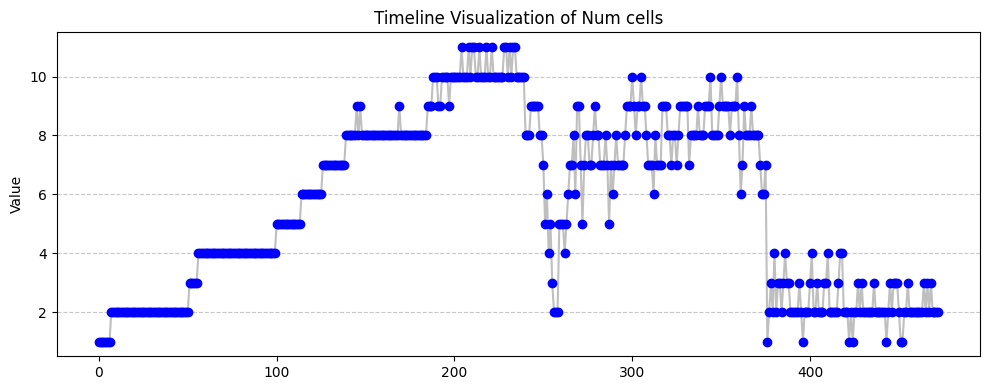

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: timestamps and corresponding numerical values
timestamps = list(range(1, len(list_numcells) + 1))
values = list_numcells

# Convert timestamps to a numerical format for plotting
x = np.arange(len(timestamps))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(x, values, color='b', zorder=2)

# Draw a horizontal line to represent the timeline
ax.plot(x, values, linestyle='-', color='gray', alpha=0.5, zorder=1)

# Format the plot
# ax.set_xticks(x)
# ax.set_xticklabels(timestamps, rotation=45, ha="right")
ax.set_ylabel("Value")
ax.set_title("Timeline Visualization of Num cells")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


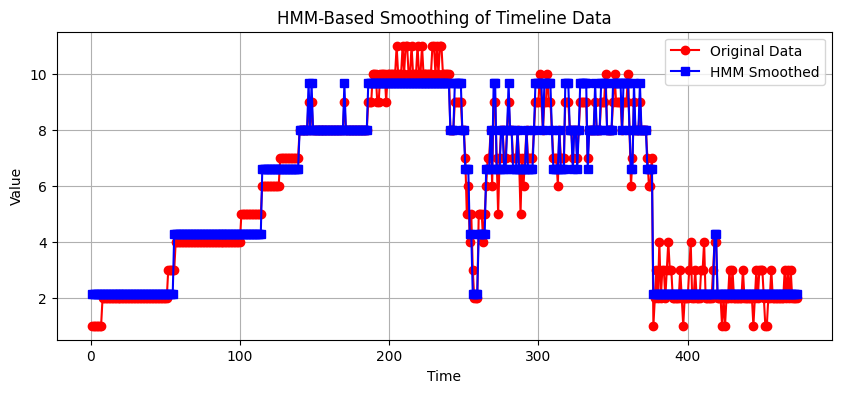

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# Example data: timestamps and noisy numerical values
timestamps = list(range(1, len(list_numcells) + 1))
values = np.array(list_numcells)

# Reshape data for HMM (hmmlearn expects 2D input)
X = values.reshape(-1, 1)

# Train HMM with Gaussian emissions (2 hidden states for smoothing)
hmm = GaussianHMM(n_components=6, covariance_type="diag", n_iter=100, random_state=42)
hmm.fit(X)

# Predict the most likely hidden states
hidden_states = hmm.predict(X)

# Compute the smoothed values using the means of the hidden states
smoothed_values = hmm.means_[hidden_states].flatten()

# Plot original vs. smoothed values
plt.figure(figsize=(10, 4))
plt.plot(timestamps, values, "o-", label="Original Data", color="red")
plt.plot(timestamps, smoothed_values, "s-", label="HMM Smoothed", color="blue")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("HMM-Based Smoothing of Timeline Data")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
%pip install hmmlearn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
